In [25]:
import os
import re

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
from sklearn.compose import make_column_transformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder

# 1. Read dataset 

In [3]:
fakepost_df = pd.read_csv("data/FakePostings.csv", index_col=0)
print(fakepost_df.head())

                                            title            location  \
job_id                                                                  
1                                Marketing Intern    US, NY, New York   
2       Customer Service - Cloud Video Production      NZ, , Auckland   
3         Commissioning Machinery Assistant (CMA)       US, IA, Wever   
4               Account Executive - Washington DC  US, DC, Washington   
5                             Bill Review Manager  US, FL, Fort Worth   

       department salary_range  \
job_id                           
1       Marketing          NaN   
2         Success          NaN   
3             NaN          NaN   
4           Sales          NaN   
5             NaN          NaN   

                                          company_profile  \
job_id                                                      
1       We're Food52, and we've created a groundbreaki...   
2       90 Seconds, the worlds Cloud Video Production ...   
3    

In [4]:
fakepost_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17880 entries, 1 to 17880
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                17880 non-null  object
 1   location             17534 non-null  object
 2   department           6333 non-null   object
 3   salary_range         2868 non-null   object
 4   company_profile      14572 non-null  object
 5   description          17879 non-null  object
 6   requirements         15184 non-null  object
 7   benefits             10668 non-null  object
 8   telecommuting        17880 non-null  int64 
 9   has_company_logo     17880 non-null  int64 
 10  has_questions        17880 non-null  int64 
 11  employment_type      14409 non-null  object
 12  required_experience  10830 non-null  object
 13  required_education   9775 non-null   object
 14  industry             12977 non-null  object
 15  function             11425 non-null  object
 16  fraudulen

# 2. EDA

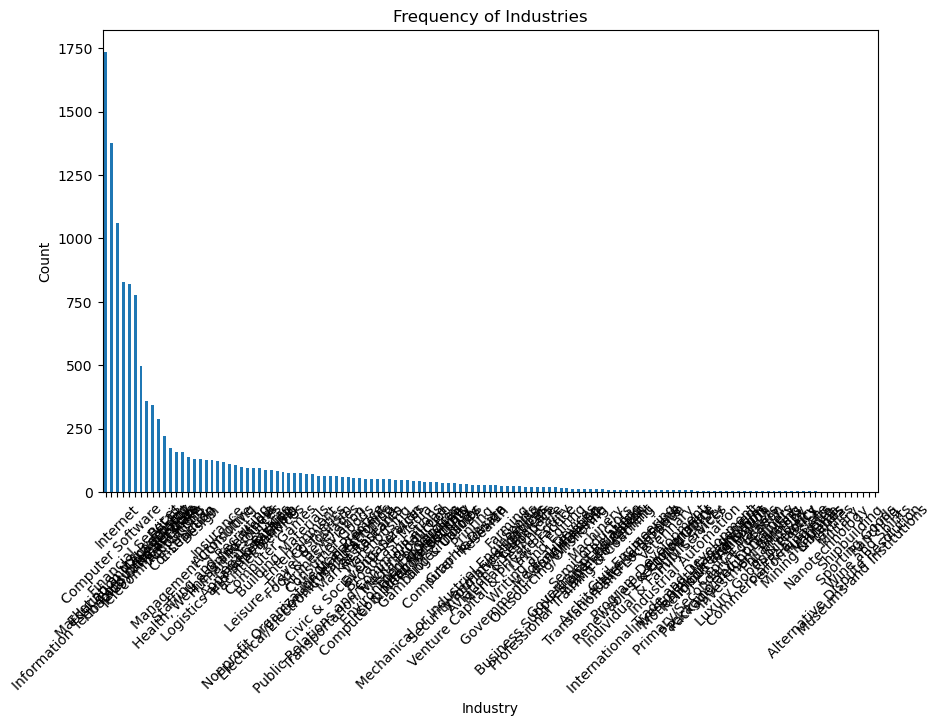

In [5]:
industry_counts = fakepost_df['industry'].value_counts()
industry_counts.plot(kind='bar', figsize=(10, 6))
plt.title('Frequency of Industries')
plt.xlabel('Industry')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


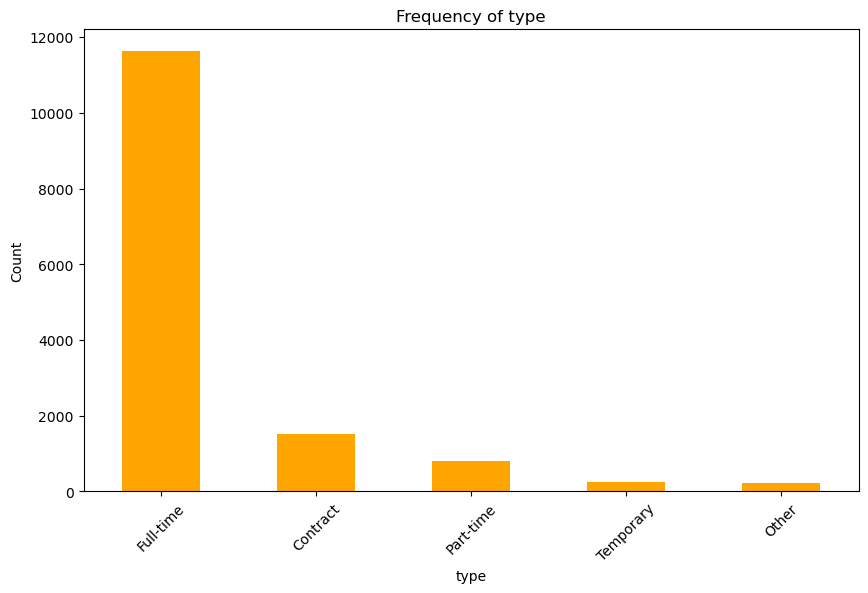

In [6]:
benefits_counts = fakepost_df['employment_type'].value_counts()

benefits_counts.plot(kind='bar', figsize=(10, 6), color='orange')
plt.title('Frequency of type')
plt.xlabel('type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


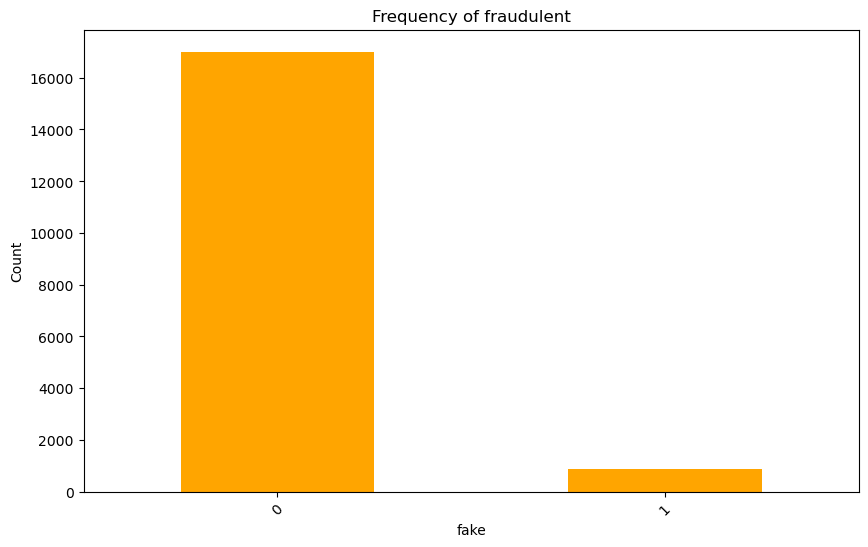

In [7]:
f_counts = fakepost_df['fraudulent'].value_counts()

f_counts.plot(kind='bar', figsize=(10, 6), color='orange')
plt.title('Frequency of fraudulent')
plt.xlabel('fake')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [8]:
fakepost_df['salary_range'] = fakepost_df['salary_range'].replace('', np.nan)

### split the salary range into lower bound and upper bound

In [9]:
#fakepost_df[['lower_bound', 'upper_bound']] = fakepost_df['salary_range'].str.split('-', expand=True)
#fakepost_df['lower_bound'] = pd.to_numeric(fakepost_df['lower_bound'], errors='coerce')
#fakepost_df['upper_bound'] = pd.to_numeric(fakepost_df['upper_bound'], errors='coerce')

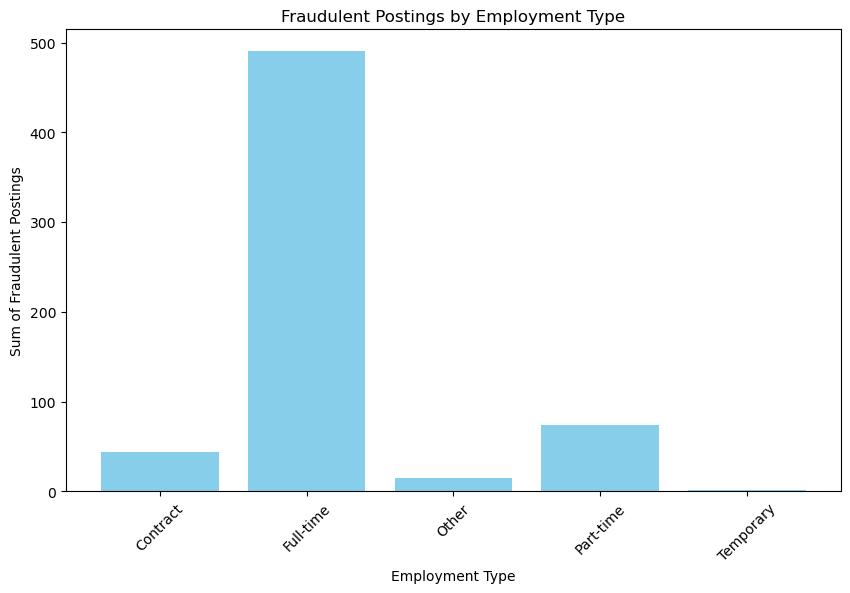

In [10]:
fraud_sum = fakepost_df.groupby('employment_type')['fraudulent'].sum()

plt.figure(figsize=(10, 6))
plt.bar(fraud_sum.index, fraud_sum.values, color='skyblue')


plt.title('Fraudulent Postings by Employment Type')
plt.xlabel('Employment Type')
plt.ylabel('Sum of Fraudulent Postings')
plt.xticks(rotation=45)
plt.show()


# 3. Data Imputation

In [11]:
text_columns = ['title', 'company_profile', 'description', 'requirements', 'benefits']
fakepost_df[text_columns] = fakepost_df[text_columns].fillna('Missing')

In [12]:
fakepost_df.isnull().mean()

title                  0.000000
location               0.019351
department             0.645805
salary_range           0.839597
company_profile        0.000000
description            0.000000
requirements           0.000000
benefits               0.000000
telecommuting          0.000000
has_company_logo       0.000000
has_questions          0.000000
employment_type        0.194128
required_experience    0.394295
required_education     0.453300
industry               0.274217
function               0.361018
fraudulent             0.000000
dtype: float64

We decide to drop salary range because it has too many null blanks. In addition, the units are not the same. Some are in thousand dollars, and some are in dollars.

In [13]:
fakepost_df = fakepost_df.drop(columns=['salary_range'])


In [14]:
fakepost_df['location'] = fakepost_df['location'].fillna('Not Specified')
fakepost_df['department'] = fakepost_df['department'].fillna('Not Specified')
fakepost_df['employment_type'] = fakepost_df['employment_type'].fillna('Not Specified')
fakepost_df['required_experience'] = fakepost_df['required_experience'].fillna('Not Specified')
fakepost_df['required_education'] = fakepost_df['required_education'].fillna('Not Specified')
fakepost_df['industry'] = fakepost_df['industry'].fillna('Not Specified')
fakepost_df['function'] = fakepost_df['function'].fillna('Not Specified')


In [15]:
fakepost_df.isnull().mean()

title                  0.0
location               0.0
department             0.0
company_profile        0.0
description            0.0
requirements           0.0
benefits               0.0
telecommuting          0.0
has_company_logo       0.0
has_questions          0.0
employment_type        0.0
required_experience    0.0
required_education     0.0
industry               0.0
function               0.0
fraudulent             0.0
dtype: float64

# 4. Preprocessing and transformation

Let's try bag of words first!

In [16]:
word_features= ['title', 'company_profile', 'description', 'requirements', 'benefits', 'location', 'department']

In [17]:
def preprocess_text(text):
    text = text.lower()  
    text = re.sub(r'\d+', '', text)  
    text = re.sub(r'[^\w\s]', ' ', text)  
    return text

In [18]:
for col in word_features:
    fakepost_df[col] = fakepost_df[col].apply(preprocess_text)

In [19]:
fakepost_df['combined_text'] = fakepost_df[word_features].apply(lambda row: ' '.join(row.astype(str)), axis=1)

# 5. Model training


## 1) bag of words

In [20]:
X_data = fakepost_df['combined_text']
y_data = fakepost_df["fraudulent"]
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.4, random_state=42)

X_train = X_train.fillna('')
X_test = X_test.fillna('')

In [21]:
vectorizer = CountVectorizer()
X_transform = vectorizer.fit_transform(X_train)

#smote = SMOTE(random_state=68)
#X_smote, y_smote = smote.fit_resample(X_transform, y_train)

In [22]:
X_test_transformed = vectorizer.transform(X_test)

In [93]:
from sklearn.metrics import recall_score, classification_report
models = {
 "RandomForest": RandomForestClassifier(random_state=123),
 "LogisticRegression": LogisticRegression(max_iter=2000, random_state=123),
 "xgboost": XGBClassifier(random_state=123, use_label_encoder=False, eval_metric='logloss')
}


for name, model in models.items():
 model.fit(X_transform, y_train)
 log_prediction = model.predict(X_test_transformed)
 recall = recall_score(y_test, log_prediction, average='binary')
 print(f"Model: {name}")
 print(f"Recall Score: {recall:.4f}")
 print("Classification Report:\n", classification_report(y_test, log_prediction))

Model: RandomForest
Recall Score: 0.5923
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      6789
           1       1.00      0.59      0.74       363

    accuracy                           0.98      7152
   macro avg       0.99      0.80      0.87      7152
weighted avg       0.98      0.98      0.98      7152

Model: kNN
Recall Score: 0.6474
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      6789
           1       0.75      0.65      0.69       363

    accuracy                           0.97      7152
   macro avg       0.86      0.82      0.84      7152
weighted avg       0.97      0.97      0.97      7152

Model: LogisticRegression
Recall Score: 0.7548
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      6789
           1       0.92      0.75      0.83  

/opt/miniconda3/envs/cpsc330/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:12:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model: xgboost
Recall Score: 0.7135
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      6789
           1       0.97      0.71      0.82       363

    accuracy                           0.98      7152
   macro avg       0.98      0.86      0.91      7152
weighted avg       0.98      0.98      0.98      7152



In [68]:
param_grid_lr = {
   "C": 10.0 ** np.arange(-1.5, 2, 0.5),
}
lr = LogisticRegression(max_iter=2000, random_state=123)
rs_lr = RandomizedSearchCV(
    estimator=lr,
    param_distributions=param_grid_lr,
    n_iter=5,
    cv=5,
    n_jobs=-1,
    #random_state=123,
    scoring='recall',
    return_train_score=True
)

rs_lr.fit(X_transform, y_train)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


RandomizedSearchCV(cv=5,
                   estimator=LogisticRegression(max_iter=2000,
                                                random_state=123),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'C': array([ 0.03162278,  0.1       ,  0.31622777,  1.        ,  3.16227766,
       10.        , 31.6227766 ])},
                   random_state=330, return_train_score=True, scoring='recall')

In [80]:
cv_results_df = pd.DataFrame(rs_lr.cv_results_)
best_lr_model = rs_lr.best_estimator_
lr_best_index = rs_lr.best_index_
y_test_pred_lr = best_lr_model.predict(X_test_transformed)
lr_best_params = rs_lr.best_params_
lr_recall = recall_score(y_test, y_test_pred_lr, average='binary') 
lr_mean_train_score = cv_results_df.loc[lr_best_index, "mean_train_score"]
lr_mean_validation_score = cv_results_df.loc[lr_best_index, "mean_test_score"]
print("Logistic Regression Best Hyperparameters:", lr_best_params)
print("Logistic Regression Mean Train Score:", lr_mean_train_score)
print("Logistic Regression Mean Validation Score:", lr_mean_validation_score)
print("Logistic Regression Test Recall Score:", lr_recall)

Logistic Regression Best Hyperparameters: {'C': 31.622776601683793}
Logistic Regression Mean Train Score: 1.0
Logistic Regression Mean Validation Score: 0.7217029702970297
Logistic Regression Test Recall Score: 0.7768595041322314


In [115]:
from sklearn.model_selection import RandomizedSearchCV

param_grid_rf = {
    "max_depth": [10, 20, 30, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5, 10],
    "n_estimators": [50, 100, 200, 300],
}
rf = RandomForestClassifier(random_state=123)
rs_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid_rf,
    n_iter=5,
    cv=7,
    n_jobs=-1,
    #random_state=123,
    scoring='recall',
    return_train_score=True
)

rs_rf.fit(X_transform, y_train)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/opt/miniconda3/envs/cpsc330/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


RandomizedSearchCV(cv=7, estimator=RandomForestClassifier(random_state=123),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, None],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200, 300]},
                   return_train_score=True, scoring='recall')

In [116]:
from sklearn.metrics import recall_score

cv_results_df = pd.DataFrame(rs_rf.cv_results_)
best_rf_model = rs_rf.best_estimator_
y_test_pred = best_rf_model.predict(X_test_transformed)
rf_best_index = rs_rf.best_index_
rf_best_params = rs_rf.best_params_
rf_mean_train_score = cv_results_df.loc[rf_best_index, "mean_train_score"]
rf_mean_validation_score = cv_results_df.loc[rf_best_index, "mean_test_score"]

rf_recall = recall_score(y_test, y_test_pred, average='binary') 

print("Random Forest Best Hyperparameters:", rf_best_params)
print("Random Forest Mean Train Score:", rf_mean_train_score)
print("Random Forest Mean Validation Score:", rf_mean_validation_score)
print("Random Forest Test Recall Score:", rf_recall)



Random Forest Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': None}
Random Forest Mean Train Score: 0.8442613768889871
Random Forest Mean Validation Score: 0.5108707802369773
Random Forest Test Recall Score: 0.5426997245179064


In [87]:
from xgboost import XGBClassifier


param_grid_xgb = {
    "n_estimators": [100, 200, 300, 400, 500],  
    "max_depth": [3, 5, 7, 10],                
    "learning_rate": [0.01, 0.05, 0.1, 0.2],         
    "gamma": [0, 1, 5],                       
}


xgb = XGBClassifier(random_state=123, use_label_encoder=False, eval_metric='logloss')


rs_xgb = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid_xgb,
    n_iter=5,                
    cv=5,                    
    n_jobs=-1,               
    random_state=330,        
    scoring='recall',         
    return_train_score=True   
)


rs_xgb.fit(X_transform, y_train)


/opt/miniconda3/envs/cpsc330/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:07:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/miniconda3/envs/cpsc330/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:07:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/miniconda3/envs/cpsc330/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:07:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/miniconda3/envs/cpsc330/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:07:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(sms

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=123, ...),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'gamma': [0, 1, 5],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 5, 7, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=330, return_train_score=True, scoring='recall')

In [91]:
from sklearn.metrics import recall_score

cv_results_df = pd.DataFrame(rs_xgb.cv_results_)

best_xgb_model = rs_xgb.best_estimator_

y_test_pred_xgb = best_xgb_model.predict(X_test_transformed)


xgb_best_index = rs_xgb.best_index_
xgb_best_params = rs_xgb.best_params_
xgb_mean_train_score = cv_results_df.loc[xgb_best_index, "mean_train_score"]
xgb_mean_validation_score = cv_results_df.loc[xgb_best_index, "mean_test_score"]

xgb_recall = recall_score(y_test, y_test_pred_xgb, average='binary')

print("XGboost Best Hyperparameters:", xgb_best_params)
print("XGboost Mean Train Score:", xgb_mean_train_score)
print("XGboost Mean Validation Score:", xgb_mean_validation_score)
print("XGboost Test Recall Score:", xgb_recall)


XGboost Best Hyperparameters: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 5}
XGboost Mean Train Score: 0.7793279261261928
XGboost Mean Validation Score: 0.5447722772277228
XGboost Test Recall Score: 0.6143250688705234


### try other models: random forest; xgboost, etc
### hyperparameter tuning

## 2)tfidVectorizer

In [28]:
X_data = fakepost_df['combined_text']
y_data = fakepost_df["fraudulent"]
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.4, random_state=42)

X_train = X_train.fillna('')
X_test = X_test.fillna('')

In [29]:
vectorizer_tf = TfidfVectorizer()
X_tf_transform = vectorizer_tf.fit_transform(X_train)


#smote = SMOTE(random_state=68)
#X_smote, y_smote = smote.fit_resample(X_tf_transform, y_train)

In [30]:
X_tf_test_transformed = vectorizer_tf.transform(X_test)

In [95]:
models = {
 "RandomForest": RandomForestClassifier(random_state=123),
  "LogisticRegression": LogisticRegression(max_iter=2000, random_state=123),
 "xgboost": XGBClassifier(random_state=123, use_label_encoder=False, eval_metric='logloss')
}
results_dict = {}
for name, model in models.items():
 model.fit(X_tf_transform, y_train)
 log_tf_prediction = model.predict(X_tf_test_transformed)
 recall = recall_score(y_test, log_tf_prediction, average='binary')
 print(f"Model: {name}")
 print(f"Recall Score: {recall:.4f}")
 print("Classification Report:\n", classification_report(y_test, log_tf_prediction))

Model: RandomForest
Recall Score: 0.5785
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      6789
           1       1.00      0.58      0.73       363

    accuracy                           0.98      7152
   macro avg       0.99      0.79      0.86      7152
weighted avg       0.98      0.98      0.98      7152

Model: LogisticRegression
Recall Score: 0.3416
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      6789
           1       0.99      0.34      0.51       363

    accuracy                           0.97      7152
   macro avg       0.98      0.67      0.75      7152
weighted avg       0.97      0.97      0.96      7152



/opt/miniconda3/envs/cpsc330/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:15:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model: xgboost
Recall Score: 0.6722
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      6789
           1       0.96      0.67      0.79       363

    accuracy                           0.98      7152
   macro avg       0.97      0.84      0.89      7152
weighted avg       0.98      0.98      0.98      7152



In [96]:
param_grid_lr = {
   "C": 10.0 ** np.arange(-1.5, 2, 0.5),
}
lr = LogisticRegression(max_iter=2000, random_state=123)
rs_lr = RandomizedSearchCV(
    estimator=lr,
    param_distributions=param_grid_lr,
    n_iter=5,
    cv=5,
    n_jobs=-1,
    random_state=330,
    scoring='recall',
    return_train_score=True
)

rs_lr.fit(X_tf_transform, y_train)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


RandomizedSearchCV(cv=5,
                   estimator=LogisticRegression(max_iter=2000,
                                                random_state=123),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'C': array([ 0.03162278,  0.1       ,  0.31622777,  1.        ,  3.16227766,
       10.        , 31.6227766 ])},
                   random_state=330, return_train_score=True, scoring='recall')

In [98]:
cv_results_df = pd.DataFrame(rs_lr.cv_results_)
best_lr_model = rs_lr.best_estimator_
lr_best_index = rs_lr.best_index_
y_test_pred_lr = best_lr_model.predict(X_tf_test_transformed)
lr_best_params = rs_lr.best_params_
lr_recall = recall_score(y_test, y_test_pred_lr, average='binary') 
lr_mean_train_score = cv_results_df.loc[lr_best_index, "mean_train_score"]
lr_mean_validation_score = cv_results_df.loc[lr_best_index, "mean_test_score"]
print("Logistic Regression Best Hyperparameters:", lr_best_params)
print("Logistic Regression Mean Train Score:", lr_mean_train_score)
print("Logistic Regression Mean Validation Score:", lr_mean_validation_score)
print("Logistic Regression Test Recall Score:", lr_recall)

Logistic Regression Best Hyperparameters: {'C': 31.622776601683793}
Logistic Regression Mean Train Score: 0.9930422330037161
Logistic Regression Mean Validation Score: 0.6480990099009901
Logistic Regression Test Recall Score: 0.7355371900826446


In [ ]:
param_grid_rf = {
    "max_depth": [10, 20, 30, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5, 10],
    "n_estimators": [50, 100, 200, 300],
}
rf = RandomForestClassifier(random_state=123)
rs_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid_rf,
    n_iter=5,
    cv=5,
    n_jobs=-1,
    random_state=330,
    scoring='recall',
    return_train_score=True
)

rs_rf.fit(X_tf_transform, y_train)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [101]:
cv_results_df = pd.DataFrame(rs_rf.cv_results_)
best_rf_model = rs_rf.best_estimator_
y_test_pred = best_rf_model.predict(X_tf_test_transformed)
rf_best_index = rs_rf.best_index_
rf_best_params = rs_rf.best_params_
rf_mean_train_score = cv_results_df.loc[rf_best_index, "mean_train_score"]
rf_mean_validation_score = cv_results_df.loc[rf_best_index, "mean_test_score"]

rf_recall = recall_score(y_test, y_test_pred, average='binary') 

print("Random Forest Best Hyperparameters:", rf_best_params)
print("Random Forest Mean Train Score:", rf_mean_train_score)
print("Random Forest Mean Validation Score:", rf_mean_validation_score)
print("Random Forest Test Recall Score:", rf_recall)

Random Forest Best Hyperparameters: {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20}
Random Forest Mean Train Score: 0.3573398516104342
Random Forest Mean Validation Score: 0.2843564356435644
Random Forest Test Recall Score: 0.3140495867768595


In [103]:

param_grid_xgb = {
    "n_estimators": [100, 200, 300, 400, 500],  
    "max_depth": [3, 5, 7, 10],                
    "learning_rate": [0.01, 0.05, 0.1, 0.2],         
    "gamma": [0, 1, 5],                       
}


xgb = XGBClassifier(random_state=123, use_label_encoder=False, eval_metric='logloss')


rs_xgb = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid_xgb,
    n_iter=5,                
    cv=5,                    
    n_jobs=-1,               
    random_state=330,        
    scoring='recall',         
    return_train_score=True   
)


rs_xgb.fit(X_tf_transform, y_train)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/opt/miniconda3/envs/cpsc330/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:18:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/miniconda3/envs/cpsc330/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:18:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/miniconda3/envs/cpsc330/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:18:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/miniconda3/envs/cpsc330/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:18:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(sms

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/opt/miniconda3/envs/cpsc330/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:21:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


KeyboardInterrupt: 

In [ ]:
cv_results_df = pd.DataFrame(rs_xgb.cv_results_)

best_xgb_model = rs_xgb.best_estimator_

y_test_pred_xgb = best_xgb_model.predict(X_tf_test_transformed)


xgb_best_index = rs_xgb.best_index_
xgb_best_params = rs_xgb.best_params_
xgb_mean_train_score = cv_results_df.loc[xgb_best_index, "mean_train_score"]
xgb_mean_validation_score = cv_results_df.loc[xgb_best_index, "mean_test_score"]

xgb_recall = recall_score(y_test, y_test_pred_xgb, average='binary')

print("XGboost Best Hyperparameters:", xgb_best_params)
print("XGboost Mean Train Score:", xgb_mean_train_score)
print("XGboost Mean Validation Score:", xgb_mean_validation_score)
print("XGboost Test Recall Score:", xgb_recall)

### try other models: random forest; xgboost, etc
### hyperparameter tuning